In [2]:
# Import All Necessary Lib
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [3]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [4]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [5]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
#Print Model Summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.70):
      print("\nReached 70.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [8]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.25)(x)                  
# Add a final softmax layer for classification
x = layers.Dense(7, activation='softmax')(x)         

model = Model(pre_trained_model.input, x) 

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# Set Variabel Here
train_dir = 'base_dir/train_dir'
validation_dir = 'base_dir/val_dir'

training_images_len = 38569
testing_images_len = 938


batch_size_train = 32
batch_size_validation = 32

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
# Image Already Augmented Previously
train_datagen = ImageDataGenerator(rescale = 1./255. )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size_train,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size_validation,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [11]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              steps_per_epoch = training_images_len/32,
                              epochs = 10,
                              callbacks = [callbacks],
                              validation_data = validation_generator,
                              validation_steps = testing_images_len/32,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1206/1205 [==============================] - 2031s 2s/step - loss: 2.3251 - acc: 0.4779 - val_loss: 1.6398 - val_acc: 0.2878
Epoch 2/10
1206/1205 [==============================] - 2046s 2s/step - loss: 1.2693 - acc: 0.5210 - val_loss: 0.6482 - val_acc: 0.8198
Epoch 3/10
1206/1205 [==============================] - 2074s 2s/step - loss: 1.2153 - acc: 0.5517 - val_loss: 0.8232 - val_acc: 0.7090
Epoch 4/10
1206/1205 [==============================] - 1991s 2s/step - loss: 1.2265 - acc: 0.5341 - val_loss: 0.6101 - val_acc: 0.8198
Epoch 5/10
1206/1205 [==============================] - 1930s 2s/step - loss: 1.2180 - acc: 0.5350 - val_loss: 0.6429 - val_acc: 0.7825
Epoch 6/10
1206/1205 [==============================] - 1923s 2s/step - loss: 1.1741 - acc: 0.5589 - val_loss: 0.6619 - val_acc: 0.7942
Epoch 7/10
1206/1205 [==============================] - 1909s 2s/step - loss: 1.1282 - acc: 0.5692 - val_los

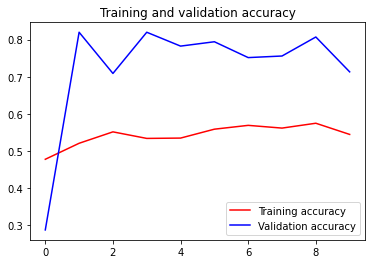

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [19]:
print("acc")
history.history['acc']

acc


[0.4779486060142517,
 0.5210142731666565,
 0.551738440990448,
 0.5341076850891113,
 0.5349892377853394,
 0.5589463114738464,
 0.5692395567893982,
 0.561876118183136,
 0.5749436020851135,
 0.5448417067527771]

In [20]:
print("val_acc")
history.history['val_acc']

val_acc


[0.28784647583961487,
 0.8198294043540955,
 0.7089552283287048,
 0.8198294043540955,
 0.7825160026550293,
 0.7942430973052979,
 0.751599133014679,
 0.7558635473251343,
 0.8070362210273743,
 0.7132196426391602]

In [21]:
print("loss")
history.history['loss']

loss


[2.325087785720825,
 1.2692527770996094,
 1.2152628898620605,
 1.2264635562896729,
 1.2180439233779907,
 1.1741392612457275,
 1.1281635761260986,
 1.152402639389038,
 1.1143543720245361,
 1.1486849784851074]

In [22]:
print("val_loss")
history.history['val_loss']

val_loss


[1.639811396598816,
 0.648181140422821,
 0.8231650590896606,
 0.6101381778717041,
 0.6429356336593628,
 0.6618744730949402,
 0.6219889521598816,
 0.6554312109947205,
 0.8316794037818909,
 0.8236529231071472]